Import packages and processed run metrics

In [16]:
# packages
import os
import re
import numpy as np
import pandas as pd

# source
helper = __import__('00_helper')

# control
top_k = 1
with_ft = 1
write_output = 0

validation_metric = 'Results/val_acc'
project_names = [
    'femnist--s02', 'sst2', 'pubmed'
    #'pubmed2'
    #'cifar--alpha5.0', 'cifar--alpha0.5', 'cifar--alpha0.1'
]

df = helper.load_data(project_names)


# Custom sorts
from pandas.api.types import CategoricalDtype
cat_method_type = CategoricalDtype(
    [
        'ditto', 'fedbn', 'fedem', 'pfedme',  # pfl-methods
        'fomaml', 'fedavg', 'exact'  # ml-methodsd
    ],
    ordered=True
)
cat_dataset_type = CategoricalDtype(
    ['femnist--s02', 'sst2', 'pubmed'],
    ordered=True
)


input datasets:
	 (681, 36)
	 (1320, 44)
	 (810, 37)
all runs: (2811, 44)


In [17]:
temp = df.loc[
    (df.dataset == 'pubmed2')
    & (df.method == 'fedem')
    ]
temp[[name for name in df.columns if re.search('sys', name)]].head()

,sys_avg/local_convergence_time_minutes,sys_avg/fl_end_time_minutes,sys_avg/local_convergence_round,sys_avg/total_model_size,sys_avg/total_flops,sys_avg/global_convergence_round,sys_avg/total_upload_bytes,sys_avg/global_convergence_time_minutes,sys_avg/total_download_bytes


In [18]:
def df_to_latex(
    df,
    id_columns,
    file_name=None,
    remove_columns=None,
    file_path='output'
):

    # remove columns not of interest
    if remove_columns is None:
        remove_columns = list()
    temp_df = df[[name for name in df.columns if name not in remove_columns]]

    # sort by id columns
    temp_df = temp_df.sort_values(by=id_columns)

    # create output file
    string_df = temp_df.to_string(
        header=True,
        index=False,
        index_names=False
    )

    # remove any leading space
    string_df = re.sub('^[\s]+', '', string_df)
    # remove leading space after newlines
    string_df = re.sub('\n[\s]+', '\n', string_df)
    # replace white space between words with table column skip
    string_df = re.sub('[ \t]+', ' & ', string_df)

    # add latex newline to end of each line
    string_df = string_df.replace('_', ' ')
    string_df = string_df.replace('\n', ' \\\\\n')
    string_df = string_df + ' \\\\'

    if file_name is not None:

        # write to file
        with open(os.path.join(file_path, f'{file_name}.txt'), 'w') as f:
            f.writelines(string_df)

    else:
        return string_df


Filter data to runs of interest
Apply summary function to filtered dataset

In [19]:
subset_df = df
subset_df['method'] = subset_df['method'].astype(cat_method_type)
subset_df['dataset'] = subset_df['dataset'].astype(cat_dataset_type)
print('input dataset:', df.shape)

## row (run) filtering
# remove extra hyper-parameter searches

subset_df = subset_df.loc[(subset_df.n_epochs < 6)]
print('\t reduce to 3 or fewer local update steps:', subset_df.shape)

subset_df = subset_df.loc[(subset_df.K < 6) | (subset_df.method != 'pfedme')]
print('\t reduce to 3 or fewer local meta-learning steps for pfedme:', subset_df.shape)

subset_df = subset_df.loc[((10 * subset_df.beta).astype('Int64') % 2 == 0) | (subset_df.method != 'exact')]
print('\t reduce beta grid for decay:', subset_df.shape)

## column (metric) filtering
subset_df = subset_df[[
    name for name in subset_df.columns
    if (
        not re.search('test', name)
        and not re.search('f1', name)
        and not re.search('loss', name)
    )
]]

def convert_SI(x):
    if pd.isna(x):
        return x

    SI = {
        'K': 1e3,
        'M': 1e6,
        'G': 1e9,
        'T': 1e12
    }

    units = re.sub('[0-9.]', '', x)
    x = float(re.sub('[^0-9.]', '', x))

    if units == '':
        return x
    return x * SI[units]


def to_SI(x, unit='G', decimals=2):
    SI = {
        'K': 1e3, 'M': 1e6,
        'G': 1e9, 'T': 1e12
    }

    assert unit in [name for name, _ in SI.items()]
    return str(round(x / SI[unit], decimals)) + f' {unit}'


#convert_SI('19.0M')

input dataset: (2811, 44)
	 reduce to 3 or fewer local update steps: (2125, 44)
	 reduce to 3 or fewer local meta-learning steps for pfedme: (2045, 44)
	 reduce beta grid for decay: (1948, 44)


In [20]:
# columns of interest
id_columns = ['dataset', 'method', validation_metric]
metrics = [name for name in subset_df.columns if re.search('^sys', name)]
print('metrics:', metrics)
object_metrics= [
    name for name, types in zip(subset_df.columns, subset_df.dtypes)
    if re.search('^sys', name)
    and types == 'object'
]

float_df = subset_df.loc[subset_df.finetune == with_ft]
float_df = float_df[id_columns + metrics]
float_df[object_metrics] = float_df[object_metrics].applymap(convert_SI).apply(pd.to_numeric)
float_df['sys_avg/total_bytes'] = float_df['sys_avg/total_download_bytes'] \
                          + float_df['sys_avg/total_upload_bytes']

# filter all non-zero
float_df = float_df.loc[
    (float_df['sys_avg/global_convergence_round'] > 0)
    & (float_df['sys_avg/global_convergence_time_minutes'] > 0)
    & (float_df['sys_avg/total_bytes'] > 0)
    & (float_df['sys_avg/total_flops'] > 0)
]

## get best runs for each group
print('before:', float_df.shape)
best_runs = float_df \
    .sort_values(by=validation_metric, ascending=False) \
    .groupby(['dataset', 'method']) \
    .head(top_k)
print('after:', best_runs.shape)


metrics: ['sys_avg/local_convergence_time_minutes', 'sys_avg/fl_end_time_minutes', 'sys_avg/local_convergence_round', 'sys_avg/total_model_size', 'sys_avg/total_flops', 'sys_avg/global_convergence_round', 'sys_avg/total_upload_bytes', 'sys_avg/global_convergence_time_minutes', 'sys_avg/total_download_bytes']
before: (776, 13)
after: (21, 13)


In [21]:
sub_metrics = [
    'sys_avg/global_convergence_round',
    'sys_avg/global_convergence_time_minutes',
    'sys_avg/total_bytes',
    'sys_avg/total_flops'
]
id_columns = ['method', 'dataset']
avg_runs = best_runs.groupby(id_columns)[sub_metrics].mean()

avg_runs['sys_avg/global_convergence_round'] = avg_runs['sys_avg/global_convergence_round'].apply(round, ndigits=2)
avg_runs['sys_avg/global_convergence_time_minutes'] = avg_runs['sys_avg/global_convergence_time_minutes'].apply(round, ndigits=2)
avg_runs['sys_avg/total_bytes2'] = avg_runs['sys_avg/total_bytes']
avg_runs['sys_avg/total_flops2'] = avg_runs['sys_avg/total_flops']
avg_runs['sys_avg/total_bytes'] = avg_runs['sys_avg/total_bytes'].apply(to_SI, unit='M')
avg_runs['sys_avg/total_flops'] = avg_runs['sys_avg/total_flops'].apply(to_SI, unit='G')
avg_runs['sys_avg/total_bytes2'] = avg_runs['sys_avg/total_bytes2'] / 1000000
avg_runs['sys_avg/total_flops2'] = avg_runs['sys_avg/total_flops2'] / 1000000000
avg_runs = avg_runs.add_suffix('_mean').reset_index()

avg_runs.columns = [re.sub('sys_avg/', '', name) for name in avg_runs.columns]
if write_output:
    df_to_latex(avg_runs, id_columns, 'method_costs--ft_' + ('yes' if with_ft else 'no'))

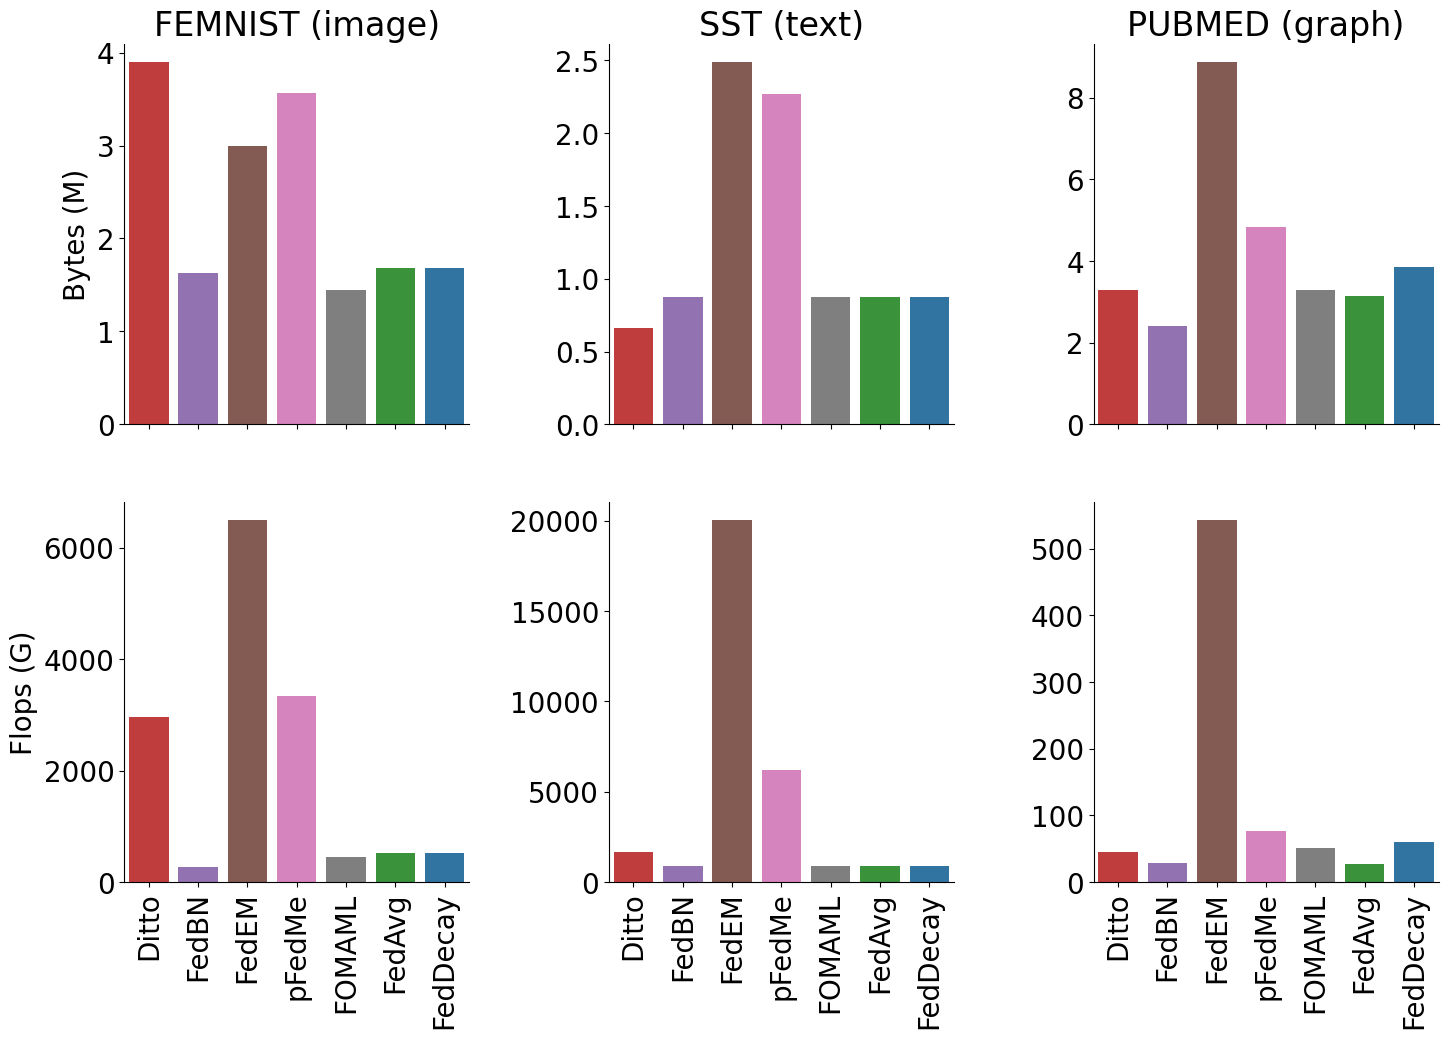

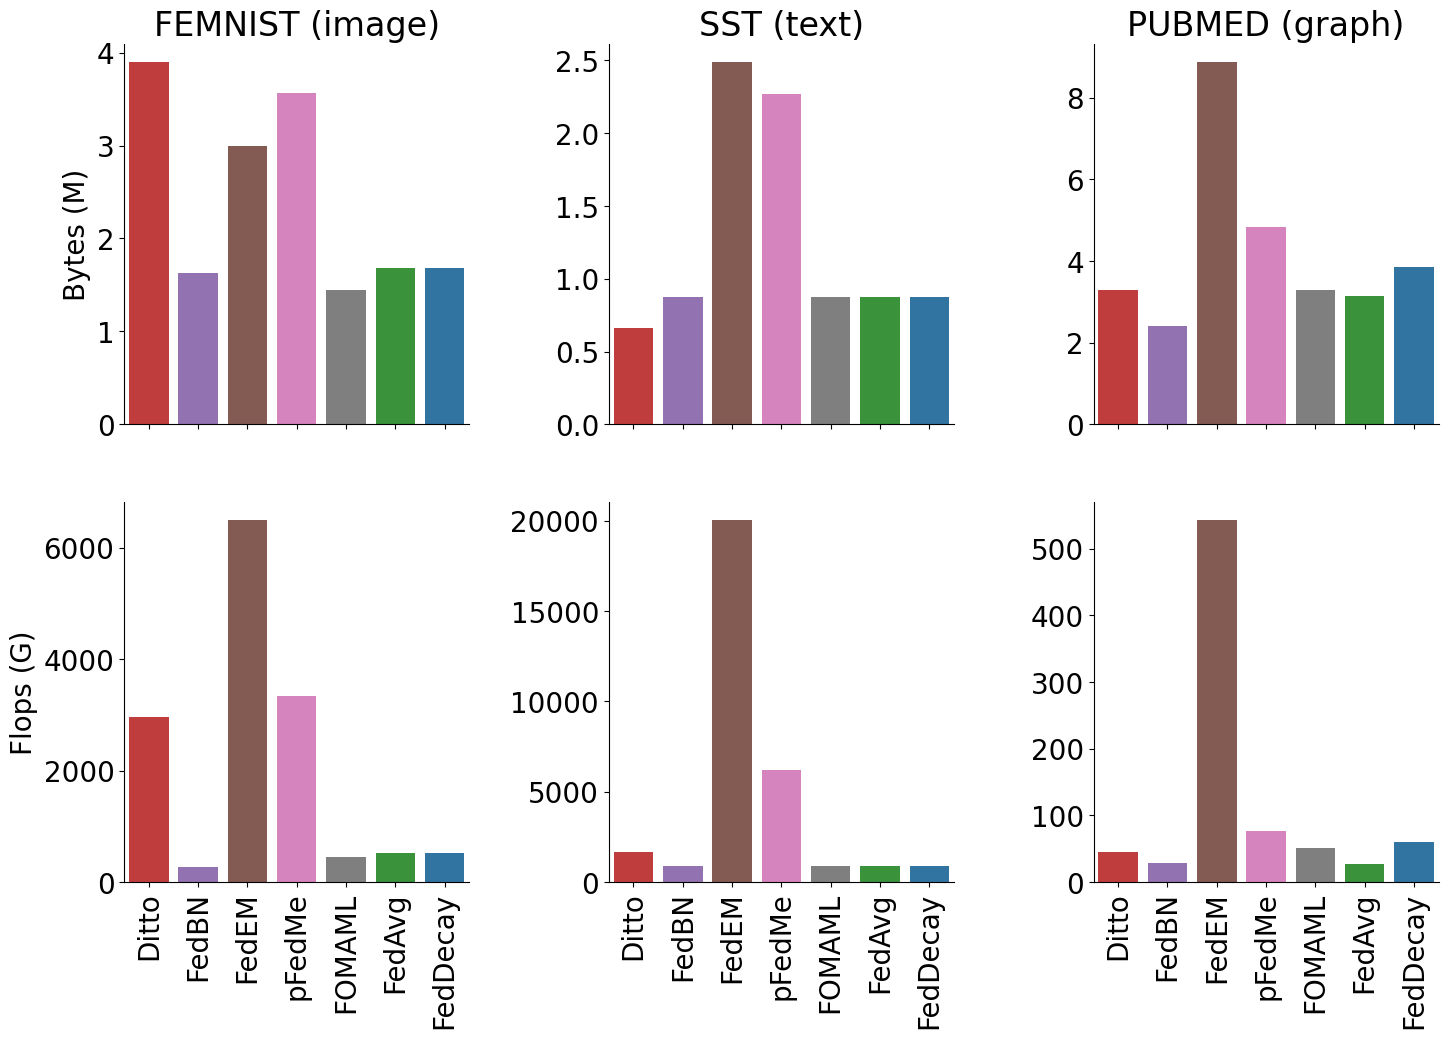

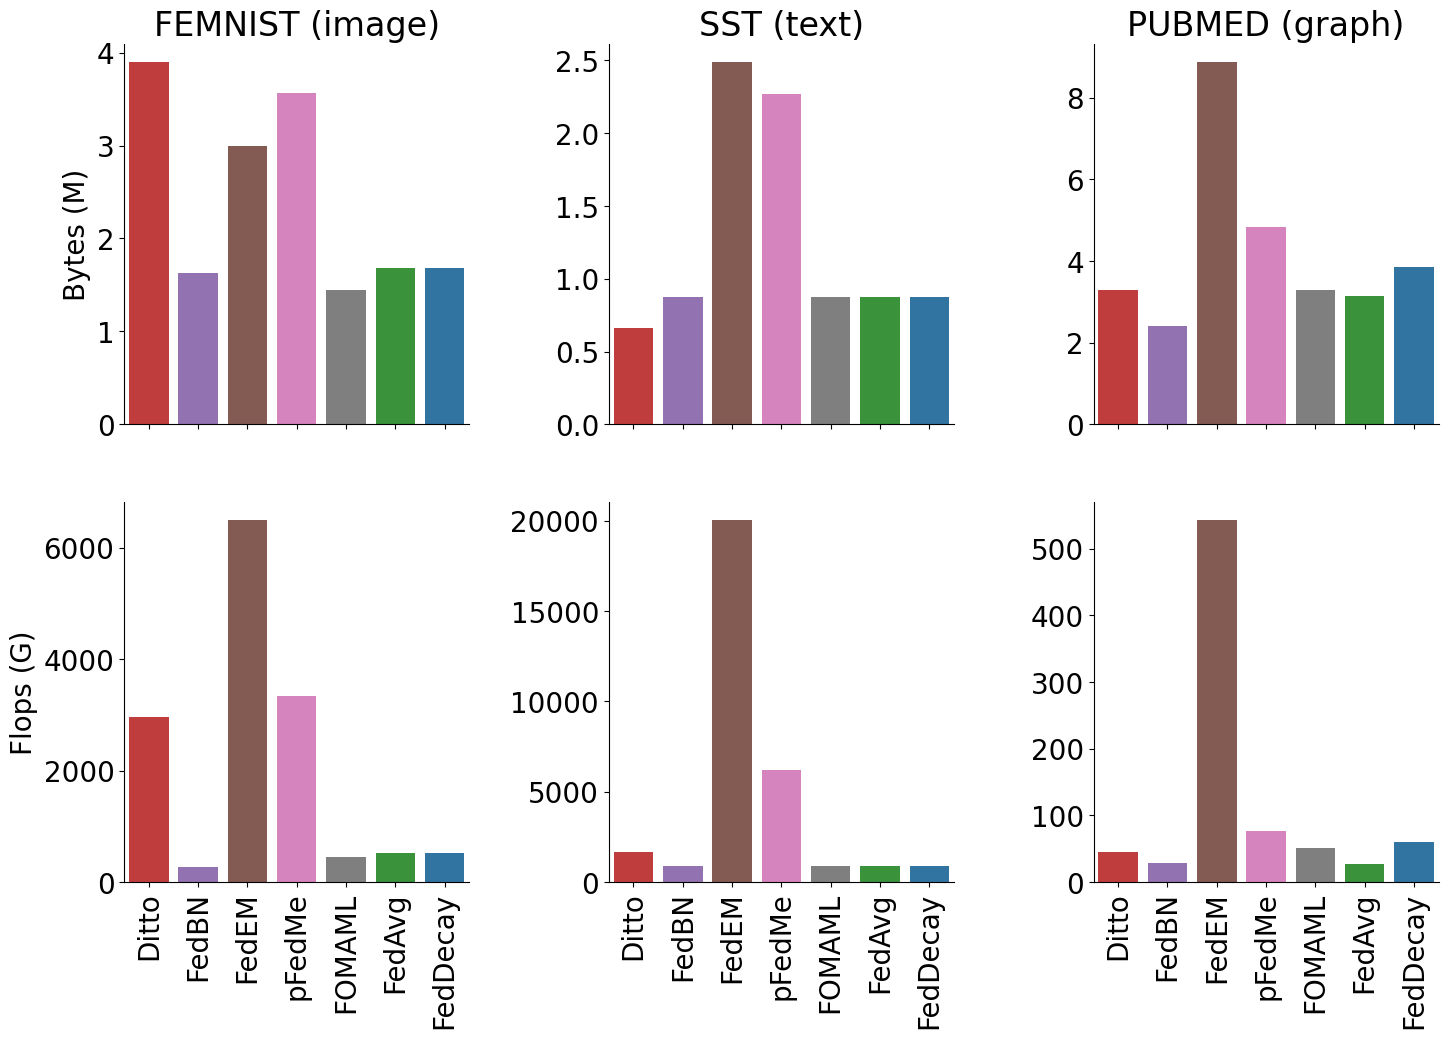

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
plt.rcParams.update({'font.size': 20})

temp = avg_runs.drop(
    ['total_bytes_mean', 'total_flops_mean'],
    #['global_convergence_time_minutes_mean', 'total_bytes_mean', 'total_flops_mean'],
    axis=1
)
temp.columns = ['method', 'dataset', 'Round', 'Time', 'Bytes', 'Flops']
#temp.columns = ['method', 'dataset', 'Round', 'Bytes', 'Flops']
temp = pd.melt(temp, id_vars=['method', 'dataset'], var_name='Cost Metric')
temp = temp.loc[[x in ['Bytes', 'Flops'] for x in temp['Cost Metric']]]

# x-axis labels
Methods = ['Ditto', 'FedBN', 'FedEM', 'pFedMe', 'FOMAML', 'FedAvg', 'FedDecay']

# colors
cp = sns.color_palette()
cp = cp[:(len(Methods) + 1)]
cp.remove(cp[1])

cp_fedavg = cp[1]
cp.remove(cp_fedavg)
cp.append(cp_fedavg)

cp_feddecay = cp[0]
cp.remove(cp_feddecay)
cp.append(cp_feddecay)

sns.set_palette(cp)

# plot
g = sns.catplot(
    data=temp,
    y='value',
    sharey=False,
    x='method', row='Cost Metric', col='dataset',
    kind='bar',
    facet_kws={'legend_out': True}
)

# set titles
Datasets = ['FEMNIST (image)', 'SST (text)', 'PUBMED (graph)']
for i, Dataset in enumerate(Datasets):
    g.axes[0, i].set_title(Dataset)
    g.axes[1, i].set_title('')
    g.axes[1, i].set_xlabel('')
    g.axes[1, i].set_xticks(ticks=range(len(Methods)), labels=Methods, rotation='vertical')

# y-axis labels
g.axes[0, 0].set_ylabel('Bytes (M)')
g.axes[1, 0].set_ylabel('Flops (G)')

plt.savefig('figures/method-costs.png', bbox_inches='tight')
